# proof of concept for reading out resonators across a broad power range

In [9]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.helpers import gauss
import time
%pylab inline
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


/usr/local/share/pynq-venv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Load bitstream with custom overlay
soc = QickSoc(bitfile="q3diamond.bit", force_init_clks=True)
soc = QickSoc(bitfile="q3diamond.bit")
dac_locked = [soc.rf.dac_tiles[iTile].PLLLockStatus==2 for iTile in soc.dac_tiles]
adc_locked = [soc.rf.adc_tiles[iTile].PLLLockStatus==2 for iTile in soc.adc_tiles]
print(dac_locked, adc_locked)

# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc

resetting clocks: 245.76 491.52
[True, True, True, True] [True]


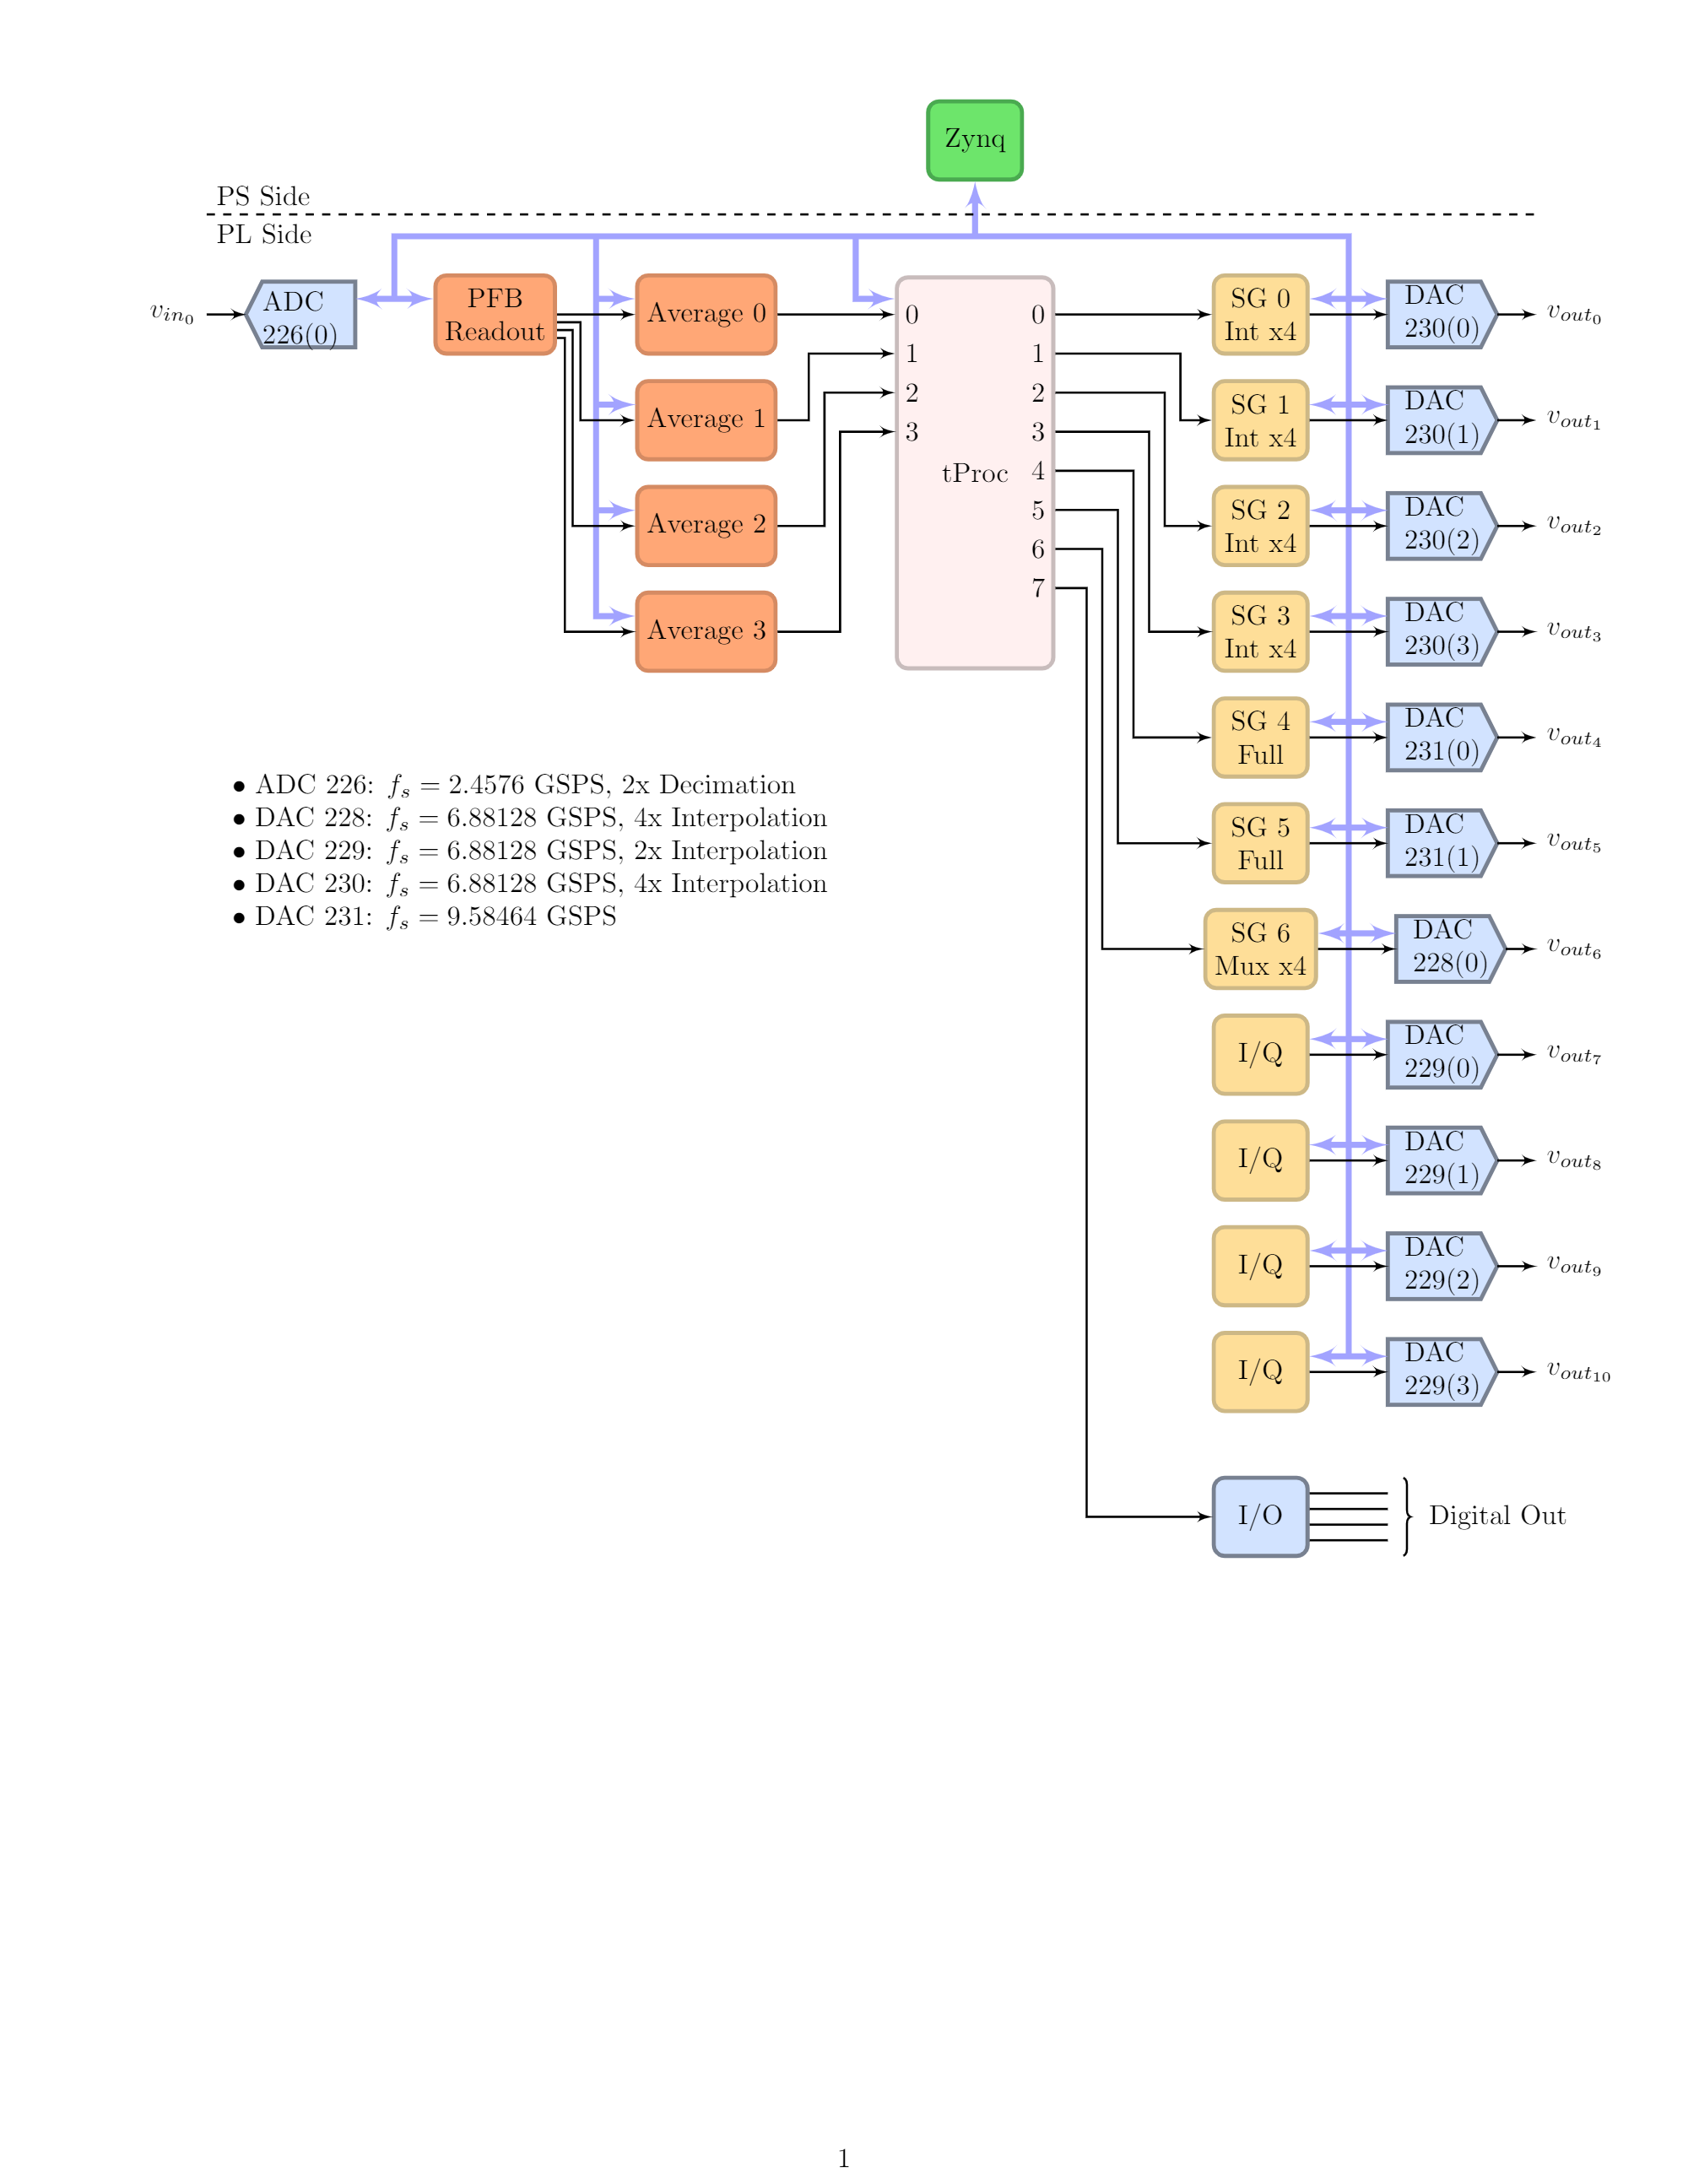

# Functions

In [3]:
class MuxProgram(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        cfg=self.cfg   
        self.declare_gen(ch=cfg["res_ch"], nqz=1, mixer_freq=cfg["mixer_freq"], mux_freqs=cfg["pulse_freqs"], ro_ch=cfg["ro_chs"][0])
        for iCh, ch in enumerate(cfg["ro_chs"]): #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, freq=cfg["pulse_freqs"][iCh], length=cfg["readout_length"], gen_ch=cfg["res_ch"])

        self.set_pulse_registers(ch=cfg["res_ch"], style="const", length=cfg["length"], mask=[0,1,2,3])
        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger(adcs=self.ro_chs, pins=[0],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"],t=0)

        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.synci(self.cfg["relax_delay"])  # sync all channels

def hangerFit(xData, freq0, QInt, Qc, asymm, offset):
    Q0 = 1 / ((1/QInt) + (1/Qc))
    return 20*np.log10(np.abs(1 - ((Q0/Qc) - 2j*Q0*asymm/(2*np.pi*freq0))/(1 + 2j*Q0*(xData-freq0)/freq0))) + offset

# Constants

In [4]:
# frequencies [MHz]
LO_f = 5e3 # local oscillator frequency
mixerCenter_f = 1500 # center frequency for the mixer
span_f = 0.003 #frequency span to sweep over. The same for all resonators
res_f = [5970, 6280, 6620, 6850] # center frequencies of the resonators

# define numbers of points
n_expts = 401 # number of points along the frequency axis
n_rounds = 5 # number of times to sweep along the frequency axis
n_reps = 100 # number of repetitions to take at each frequency point

# timing. Units are clock cycles, but converted from us
ring_up_time = soc.us2cycles(500) # time waiting for the resonator to ring up at the start of each sweep
ring_between_time = soc.us2cycles(5) # time to wait between adjacent frequency points
readout_length = soc.us2cycles(50) #time to average over
relax_delay = soc.us2cycles(0.1) #time to wait between the end of the readout and moving to the next frequency point

# power [dBm]
basePower = -30 # approximate base power common to all frequencies. Not used in calculations, only for filenames
attenList = [0] # list of attenuations to sweep over. Set to a list of len 1 to do one sweep

# computed values
mixerArray_f = np.linspace(mixerCenter_f-span_f/2, mixerCenter_f+span_f/2, n_expts)
pulse_freqs = [i-LO_f-mixerCenter_f for i in res_f]
resArray_f = [np.linspace(res_f[i]-span_f/2, res_f[i]+span_f/2, n_expts) for i in range(4)]

print('Pulse frequencies are: {0} MHz'.format(pulse_freqs))
print('Frequencies out are: {0} MHz'.format([i-LO_f for i in res_f]))



Pulse frequencies are: [-530.0, -220.0, 120.0, 350.0] MHz
Frequencies out are: [970.0, 1280.0, 1620.0, 1850.0] MHz


# check range of ADC values

In [5]:
config={"res_ch":6, # --Fixed
        "mixer_freq":mixerCenter_f, # MHz
        "ro_chs":[0,1,2,3], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":relax_delay, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":2**31-1, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_freqs": pulse_freqs,
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": ring_up_time, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":50,
        # Try varying soft_avgs from 1 to 200 averages
        }

###################
# Try it yourself !
###################

prog =MuxProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)

  0%|          | 0/50 [00:00<?, ?it/s]

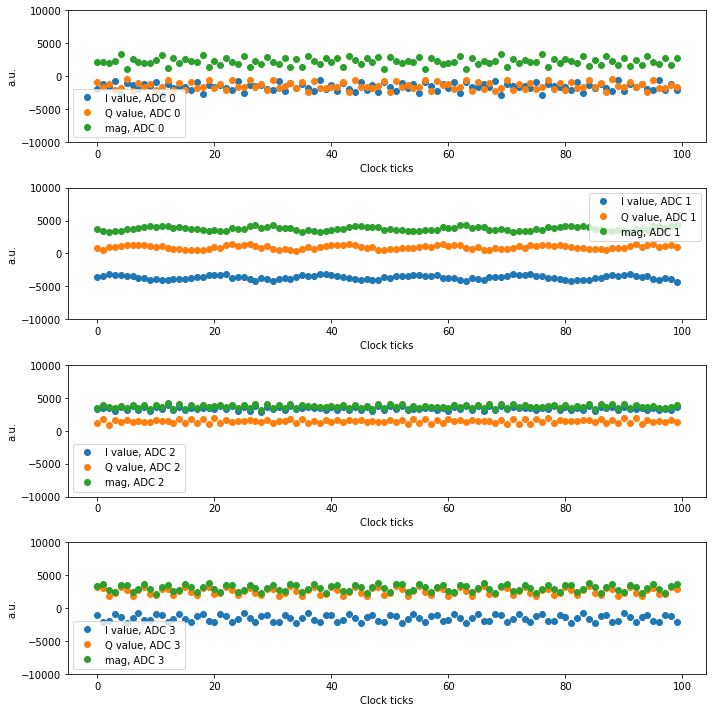

In [6]:
# Plot results.
fig, axs = plt.subplots(4,1,figsize=(10,10))

for ii, iq in enumerate(iq_list):
    plot = axs[ii]
    plot.plot(iq[0], 'o', label="I value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(iq[1], 'o',label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(np.abs(iq[0]+1j*iq[1]), 'o', label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_ylim([-10000,10000])
    plot.set_xlabel("Clock ticks")
    #plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend()

plt.tight_layout()
    

# Acquire pulses

In [7]:
config={
        # constant for the current firmware
        "res_ch":6, # --Fixed
        "ro_chs":[0,1,2,3], # --Fixed
        "pulse_style": "const", # --Fixed
        "length":2**31-1, # [Clock ticks], set to maximum allowable length
        
        # constant for the given experiment
        "readout_length":readout_length, # [Clock ticks]
        "relax_delay":relax_delay, # --Fixed
        "pulse_freqs": pulse_freqs,
        
        # will be altered during the experiment
        "adc_trig_offset": [], # [Clock ticks]
        "reps":[], # --Fixed
        "mixer_freq": [], # MHz
       }

iqListRound = [[] for i in mixerArray_f]
IArray = [np.asarray([0. for ii in mixerArray_f]) for i in range(4)]
QArray = [np.asarray([0. for ii in mixerArray_f]) for i in range(4)]

start = time.time()
# for attenInd, atten in enumerate(attenList):
for roundInd in range(n_rounds):
    roundStart = time.time()
    # ring up the resonator
    config['adc_trig_offset'] = ring_up_time
    config['reps'] = 2
    config['mixer_freq'] = mixerArray_f[0]

    prog = MuxProgram(soccfg, config)
    dummy = prog.acquire(soc, load_pulses=True, debug=False)

    # sweep across the frequency range
    config['adc_trig_offset'] = ring_between_time
    config['reps'] = n_reps
    for fInd, f in enumerate(mixerArray_f):
        config['mixer_freq'] = f
        prog =MuxProgram(soccfg, config)
        iqListRound[fInd] = prog.acquire(soc, load_pulses=True, debug=False)
    
    # add the frequencies to older measurements
    for IQInd in range(4):
        for freqInd, iq in enumerate(iqListRound):
            IArray[IQInd][freqInd] += np.asarray(iq[0][IQInd])
            QArray[IQInd][freqInd] += np.asarray(iq[1][IQInd])

    print('Round {0}, time {1:0.3f} s'.format(roundInd, time.time()-roundStart))

print('Final time = {0:0.3f} s'.format(time.time()-start))

# normalize measurements and find amplitudes
for i, dummy in enumerate(IArray):
    IArray[i] = IArray[i]/n_rounds
    QArray[i] = QArray[i]/n_rounds
ampArray = [np.abs(IArray[i]+ 1j*Q) for i, Q in enumerate(QArray)]
ampArray_log = [10*np.log10(amp) for amp in ampArray]

Round 0, time 19.319 s
Round 1, time 19.344 s
Round 2, time 19.309 s
Round 3, time 19.306 s
Round 4, time 19.305 s
Final time = 96.586 s


In [11]:
# fit resonator traces to results
pOpt = [[] for i in range(4)]
pCov = [[] for i in range(4)]
for i in range(4):
    pOpt[i], pCov[i] = curve_fit(hangerFit, (resArray_f[i])*10**6, ampArray_log[i], p0=[(res_f[i])*10**6, 5e5, 5e5, 0.5e3, 0], maxfev=100000)

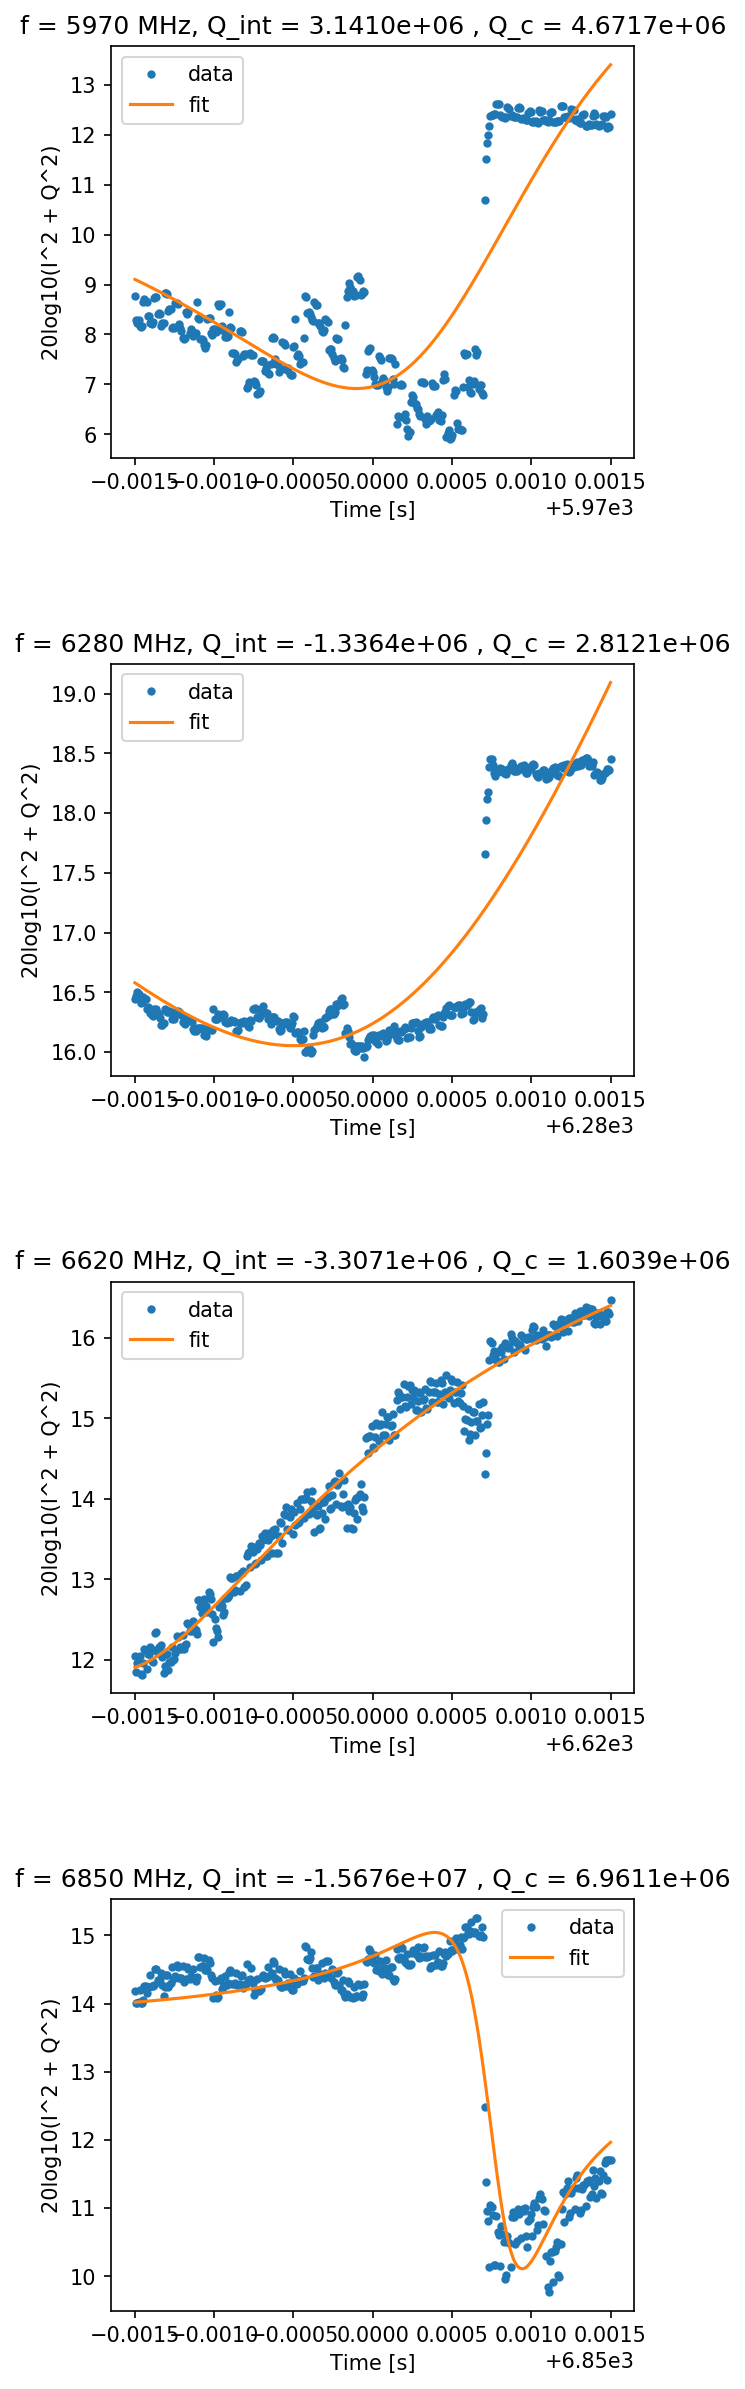

In [19]:
# plot results
fig, axs = plt.subplots(4,1,figsize=(4.5,20), dpi = 150)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

for i in range(4):  
    axs[i].plot(resArray_f[i], ampArray_log[i], '.', label='data')
    axs[i].plot(resArray_f[i], hangerFit((resArray_f[i])*10**6, *pOpt[i]), label='fit')
    axs[i].set_ylabel('20log10(I^2 + Q^2)')
    axs[i].set_xlabel('Time [s]')
    axs[i].legend(loc='best')
    axs[i].set_title('f = {0:.0f} MHz, Q_int = {1:0.4e} , Q_c = {2:0.4e}'.format(res_f[i], pOpt[i][1], pOpt[i][2]))